In [5]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter("ignore")
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


from xgboost import XGBClassifier
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
pd.set_option('display.max_columns', 500)

In [3]:
df = pd.read_csv('DataSets/Xgboost baseline/atp_tennis.csv')

In [6]:
df_num = df.drop(['Tournament', 'Date', 'score', 'Series', 'Court', 'Surface', 'Round', 'Best of'], axis = 1)
df_cat = pd.get_dummies(df[['Court', 'Surface' ]])
df_full = df_num.join(df_cat)

df_full = df_full.loc[df_full['Winner'].isin(
    df_full['Winner'].value_counts().index[df_full['Winner'].value_counts() > 2])].reset_index(drop=True)

In [7]:
p = sorted(set(df_full['Player_1']) | set(df_full['Player_2']))
dict_players = dict(zip(p, [i for i in range(len(p))]))
df_full['Player_1'] = df_full['Player_1'].apply(lambda x: dict_players[x])
df_full['Player_2'] = df_full['Player_2'].apply(lambda x: dict_players[x])
df_full['Winner'] = df_full['Winner'].apply(lambda x: dict_players[x])

In [8]:
X = df_full.drop(['Winner'], axis = 1)
y = df_full['Winner']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
%%time
le = LabelEncoder()
train = le.fit_transform(y_train)
model = XGBClassifier(random_state=42)
model.fit(X_train, train)
f1_score(y_test, le.inverse_transform(model.predict(X_test)), average = 'weighted')

Wall time: 1min 36s


0.6288993615827205

<AxesSubplot:>

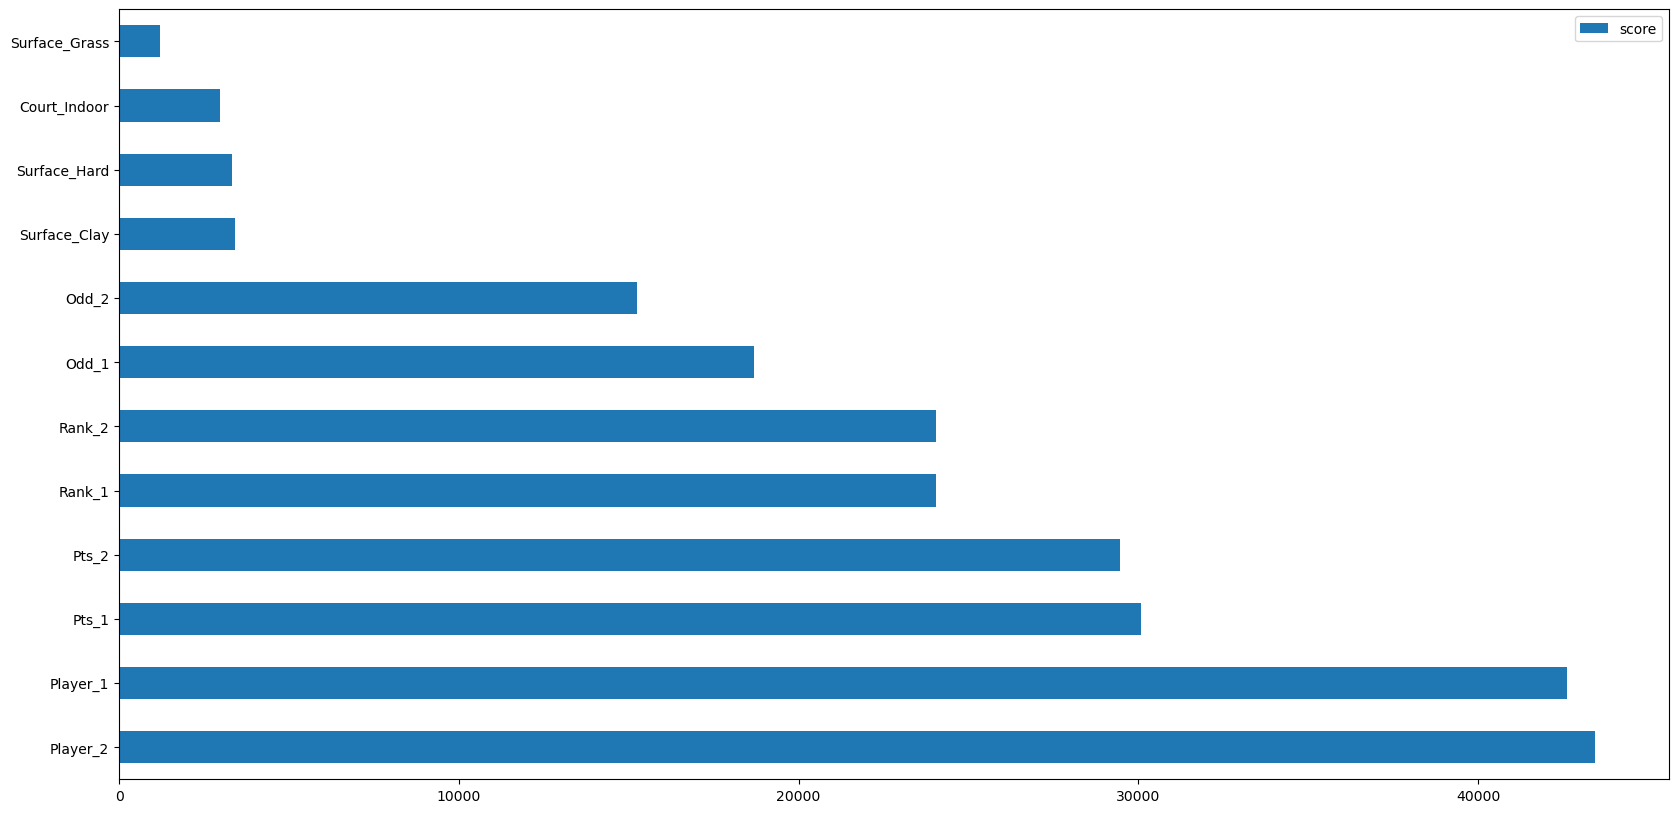

In [10]:
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10))

In [11]:
# hyperopt
'''
def hyperopt_xgb_score(params):
    train = le.fit_transform(y_train)
    clf = XGBClassifier(**params, random_state=42).fit(X_train, train)
    y_pred = clf.predict(X_test)
    y_pred = le.inverse_transform(y_pred)
    current_score = f1_score(y_test, y_pred, average = 'weighted')
    return -current_score


space_xgb2 = {
            'n_estimators': hp.choice('n_estimators', range(100, 2000)),
            'eta': hp.quniform('eta', 0.025, 1, 0.025),
            'max_depth':  hp.choice('max_depth', np.arange(1, 28, dtype=int)),
            'min_child_weight': hp.quniform('min_child_weight', 1, 12, 1),
            'subsample': hp.quniform('subsample', 0, 1, 0.05),
            'gamma': hp.quniform('gamma', 0, 1, 0.05),
            'colsample_bytree': hp.quniform('colsample_bytree', 0, 1, 0.05),
            'eval_metric': 'auc',
            'objective': 'binary:logistic',
            'booster': 'gbtree',
            'tree_method': 'exact',
            'silent': 1
        }

best = fmin(fn=hyperopt_xgb_score, space=space_xgb2, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)
'''

"\ndef hyperopt_xgb_score(params):\n    train = le.fit_transform(y_train)\n    clf = XGBClassifier(**params, random_state=42).fit(X_train, train)\n    y_pred = clf.predict(X_test)\n    y_pred = le.inverse_transform(y_pred)\n    current_score = f1_score(y_test, y_pred, average = 'weighted')\n    return -current_score\n \n \nspace_xgb2 = {\n            'n_estimators': hp.choice('n_estimators', range(100, 2000)),\n            'eta': hp.quniform('eta', 0.025, 1, 0.025),\n            'max_depth':  hp.choice('max_depth', np.arange(1, 28, dtype=int)),\n            'min_child_weight': hp.quniform('min_child_weight', 1, 12, 1),\n            'subsample': hp.quniform('subsample', 0, 1, 0.05),\n            'gamma': hp.quniform('gamma', 0, 1, 0.05),\n            'colsample_bytree': hp.quniform('colsample_bytree', 0, 1, 0.05),\n            'eval_metric': 'auc',\n            'objective': 'binary:logistic',\n            'booster': 'gbtree',\n            'tree_method': 'exact',\n            'silent': 1